In [ ]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# os
import os
# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# tf
import tensorflow as tf
# keras
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, GRU, LSTM, SimpleRNN, Dense, Activation, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.regularizers import l1,l2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import btc
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NN - 434/btc.csv')

In [ ]:
df.head()

Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [ ]:
# Drop extraneous columns
df.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], axis = 1, inplace = True)
# Drop bottom 3m rows and top 800k
df.drop(df.index[:3000000], axis = 0, inplace = True)
df.drop(df.index[4000000:], axis = 0, inplace = True)
# Reset index; drop column
df.reset_index(drop = True, inplace = True)
# Backfill na's
df.fillna(method = 'backfill', inplace = True)

In [ ]:
# RNN target/features
features = ['Weighted_Price']
target = 'Weighted_Price'

In [ ]:
# Split train sets
train_weight = 0.8
df_split = int( len(df) * train_weight )

train = df.iloc[:df_split]
test = df.iloc[df_split:]

In [ ]:
# Scaling parameters
mu = float( train[features].mean() )
sigma = float( train[features].std() )

# Scale data
train = train[features].apply( lambda x: (x - mu) / sigma )
test = test[features].apply( lambda x: (x - mu) / sigma )

In [ ]:
'''
Function for reshaping data into one-step ahead time series prediction format
    value: feature value to be lagged
    n_steps: number of steps/sequence length
    n_steps_ahead: forecasting horizon
'''

def get_lagged_features(value, n_steps, n_steps_ahead):
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append( value.shift(lag) )
    return pd.concat(lag_list, axis = 1)

In [ ]:
# Number of steps (used when debugging & ADF is commented out)
n_steps = 3
n_steps_ahead = n_steps

# Transform training input and output data
col_ords = []
for i in range(n_steps):
    for j in range(len(features)):
        col_ords.append(i + j * n_steps)

x_train_list = []
for f in features:
    x_train_reg = get_lagged_features(train, n_steps, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis = 1)
        
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int( x_train_reg.shape[1] / len(features)), len(features) ) )
y_train_reg = np.reshape( y_train_reg, (y_train_reg.shape[0], 1, 1))

In [ ]:
# Transform test input and output data
x_test_list = []
for f in features:
    x_test_reg = get_lagged_features(test, n_steps, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis = 1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int( x_test_reg.shape[1] / len(features)), len(features) ) )
y_test_reg = np.reshape( y_test_reg, (y_test_reg.shape[0], 1, 1))

In [ ]:
# Verify tensor shapes
#   value 1: # of observations
#   value 2: sequence length, or number of lags
#   value 3: dimension of each element in the sequence (x) or output vector (y): this is univariate time analysis, so the dimension of I/O is 1

print(x_train_reg.shape)
print(y_train_reg.shape)
print(x_test_reg.shape)
print(y_test_reg.shape)

(1485896, 3, 1)
(1485896, 1, 1)
(371471, 3, 1)
(371471, 1, 1)


In [ ]:
# Append lagged lists to train data
x_train_reg = pd.concat(x_train_list, axis = 1)
# Reshape
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int(x_train_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Append lagged lists to test data
x_test_reg = pd.concat(x_test_list, axis = 1)
# Reshape
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int(x_test_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Custom activation function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
# NN structures - tanh

def _RNN(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'tanh', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _LSTM(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        LSTM(n_units,
             activation = 'tanh',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _GRU(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        GRU(n_units,
             activation = 'tanh',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [ ]:
# NN structures - SWISH
def _sRNN(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _sLSTM(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        LSTM(n_units,
             activation = 'swish',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _sGRU(n_units = 10, l1_reg = 0, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add(
        GRU(n_units,
             activation = 'swish',
             kernel_initializer = keras.initializers.glorot_uniform(seed), 
             bias_initializer = keras.initializers.glorot_uniform(seed), 
             recurrent_initializer = keras.initializers.orthogonal(seed), 
             kernel_regularizer = l1(l1_reg), 
             input_shape = (x_train_reg.shape[1], x_train_reg.shape[-1]),
             unroll = True,
             stateful = False) )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [ ]:
# NN models
params = {
    'rnn': {'model':{}, 'function':_RNN, 'l1_reg':0.00001, 'H':12, 'color':'orange', 'label':'RNN', 'history':{}, 'MSE_train':{}, 'MSE_test':{}, 'predict':{}},
    'lstm': {'model':{}, 'function':_LSTM, 'l1_reg':0.00005, 'H':10, 'color':'blue', 'label':'LSTM', 'history':{}, 'MSE_train':{}, 'MSE_test':{}, 'predict':{}},
    'gru': {'model':{}, 'function':_GRU, 'l1_reg':0.00005, 'H':8, 'color':'blue', 'label':'GRU', 'history':{}, 'MSE_train':{}, 'MSE_test':{}, 'predict':{}},
    'srnn': {'model':{}, 'function':_sRNN, 'l1_reg':0.0001, 'H':10, 'color':'orange', 'label':'sRNN', 'history':{}, 'MSE_train':{}, 'MSE_test':{}, 'predict':{}},
    'slstm': {'model':{}, 'function':_sLSTM, 'l1_reg':0.00005, 'H':8, 'color':'blue', 'label':'sLSTM', 'history':{}, 'MSE_train':{}, 'MSE_test':{}, 'predict':{}},
    'sgru': {'model':{}, 'function':_sGRU, 'l1_reg':0.00001, 'H':12, 'color':'blue', 'label':'sGRU', 'history':{}, 'MSE_train':{}, 'MSE_test':{}, 'predict':{}}
}

In [ ]:
# Implement early stopping monitor to speed up cross validation
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 1, patience = 100, 
                   min_delta = 1e-7, restore_best_weights = True)

In [ ]:
# Parameters
n_epoches = 10
batches = [50, 100, 200, 400, 600, 800, 1000]
colors = {
    50:'red',
    100:'darkorange',
    200:'yellow',
    400:'green',
    600:'deepskyblue',
    800:'blue',
    1000:'purple'
}

In [ ]:
# Store step lag for ease of indexing
step_lag = n_steps + n_steps_ahead - 1

In [ ]:
# Train
for k in params.keys():
    for b in batches:
        tf.random.set_seed(0)
        model = params[k]['function'](params[k]['H'], params[k]['l1_reg'] )
        params[k]['history'][b] = model.fit(x_train_reg, y_train_reg, epochs = n_epoches, 
                                        batch_size = b, callbacks = [es], shuffle = False)
        params[k]['model'][b] = model

Epoch 1/10
29718/29718 [==============================] - 90s 3ms/step - loss: 0.0018
Epoch 2/10
29718/29718 [==============================] - 88s 3ms/step - loss: 8.2934e-04
Epoch 3/10
29718/29718 [==============================] - 86s 3ms/step - loss: 7.8481e-04
Epoch 4/10
29718/29718 [==============================] - 87s 3ms/step - loss: 8.3713e-04
Epoch 5/10
29718/29718 [==============================] - 86s 3ms/step - loss: 8.8601e-04
Epoch 6/10
29718/29718 [==============================] - 85s 3ms/step - loss: 7.4385e-04
Epoch 7/10
29718/29718 [==============================] - 86s 3ms/step - loss: 7.7736e-04
Epoch 8/10
29718/29718 [==============================] - 85s 3ms/step - loss: 6.6001e-04
Epoch 9/10
29718/29718 [==============================] - 86s 3ms/step - loss: 6.1678e-04
Epoch 10/10
29718/29718 [==============================] - 86s 3ms/step - loss: 5.6069e-04
Epoch 1/10
14859/14859 [==============================] - 44s 3ms/step - loss: 0.0037
Epoch 2/10
14859/

In [ ]:
# Prediction on test and train data with NN models
for k in params.keys():
    for b in batches:
        model = params[k]['model'][b]
        model.summary()

        params[k]['MSE_train'][b] = mean_squared_error(train[features][step_lag:], model.predict(x_train_reg, verbose = 1))
        params[k]['predict'][b] = model.predict(x_test_reg, verbose = 1)
        params[k]['MSE_test'][b] = mean_squared_error(test[features][step_lag:], params[k]['predict'][b])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12)                168       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
11609/11609 [==============================] - 18s 2ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 12)                168       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                          

In [62]:
# Graph parameter
upper_limit = 200

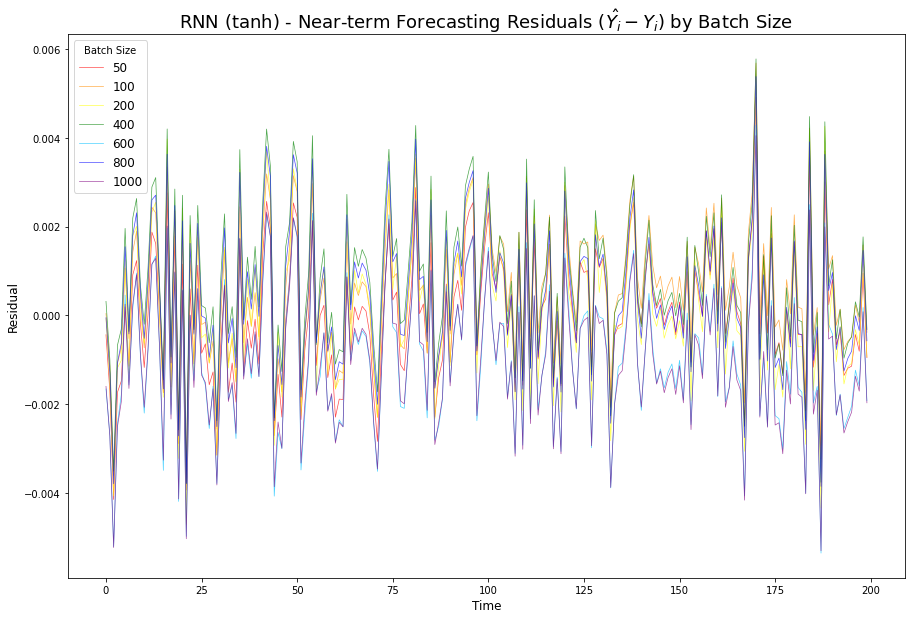

In [63]:
# Plot near_term forecasting residuals for test set -- RNN
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['rnn']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('RNN (tanh) - Near-term Forecasting Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

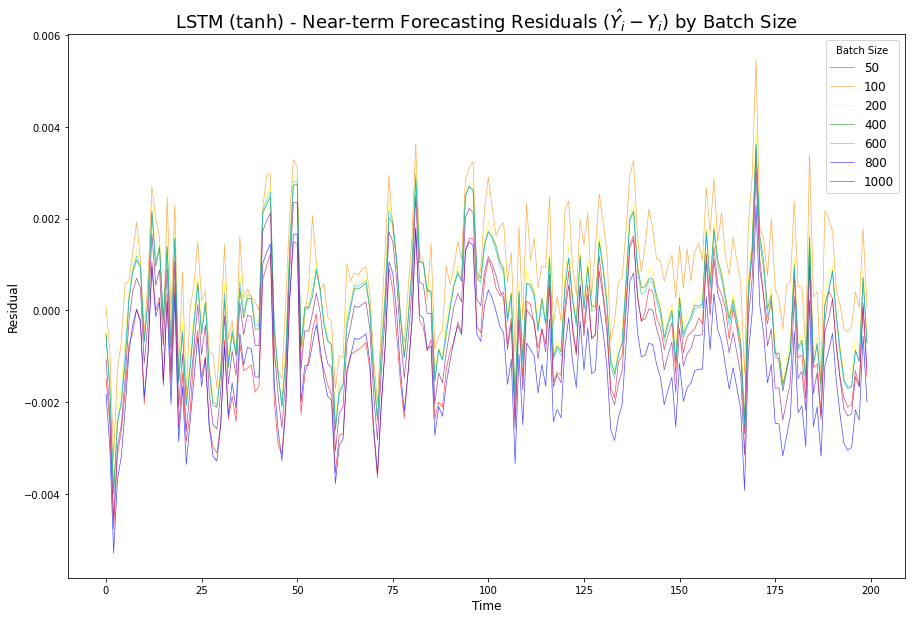

In [64]:
# Plot near_term forecasting residuals for test set -- LSTM
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['lstm']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('LSTM (tanh) - Near-term Forecasting Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

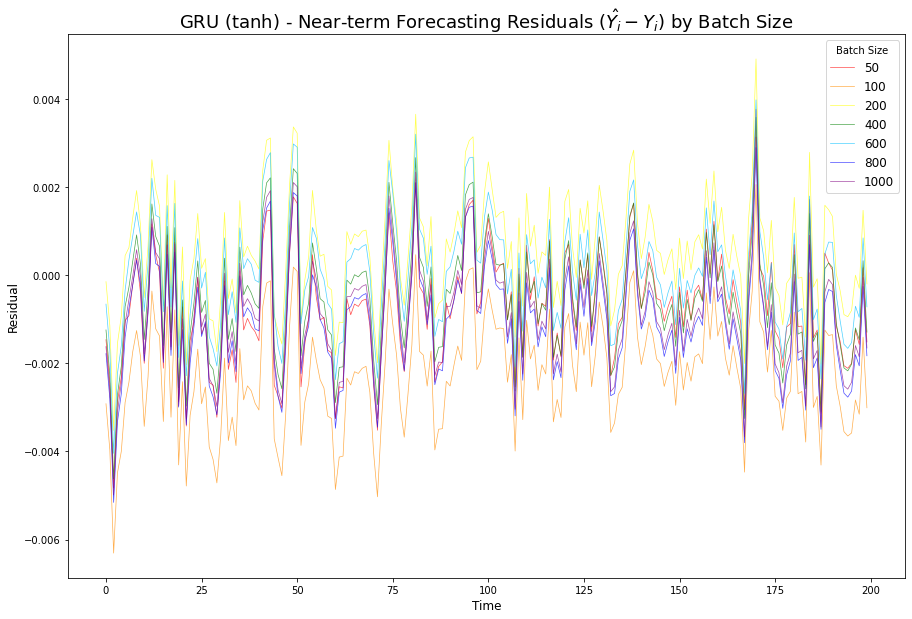

In [65]:
# Plot near_term forecasting residuals for test set -- GRU
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['gru']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('GRU (tanh) - Near-term Forecasting Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

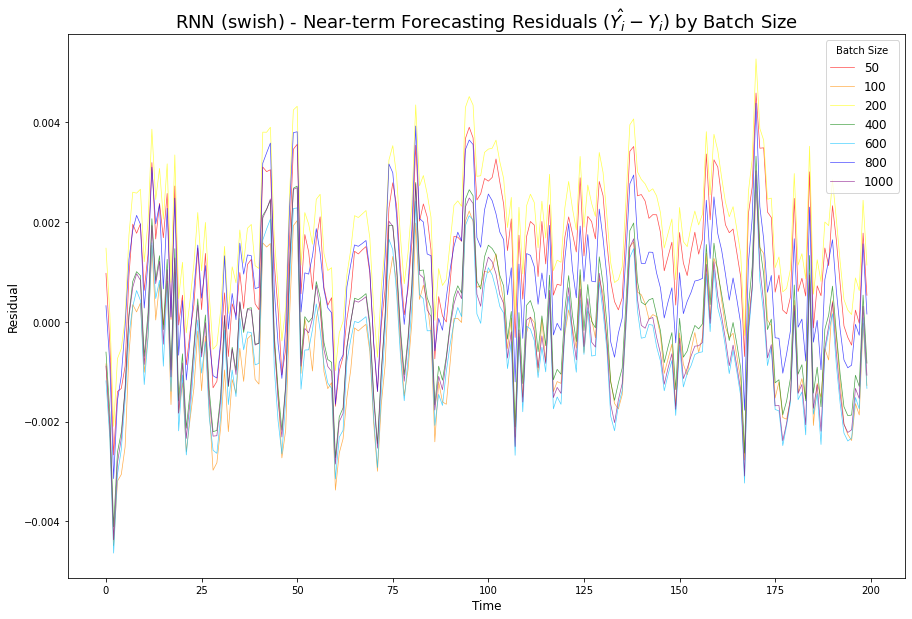

In [66]:
# Plot near_term forecasting residuals for test set -- sRNN
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['srnn']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('RNN (swish) - Near-term Forecasting Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

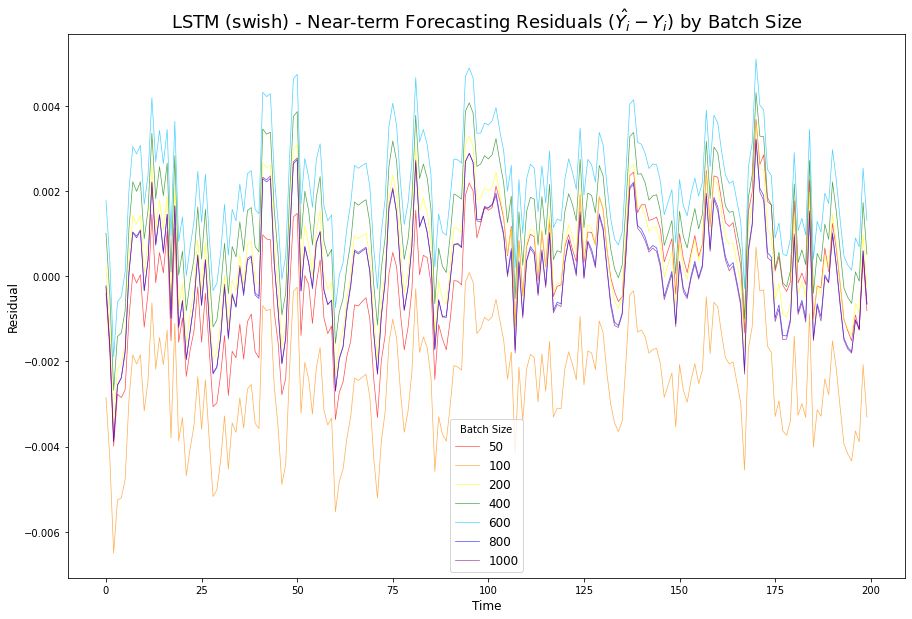

In [67]:
# Plot near_term forecasting residuals for test set -- sLSTM
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['slstm']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('LSTM (swish) - Near-term Forecasting Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

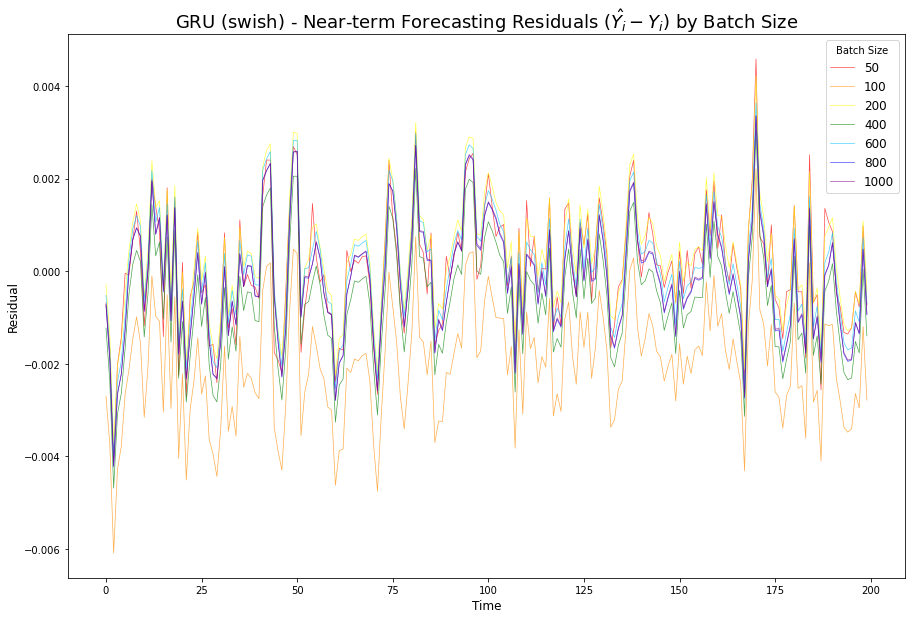

In [68]:
# Plot near_term forecasting residuals for test set -- sGRU
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['sgru']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('GRU (swish) - Near-term Forecasting Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

In [69]:
upper_limit = 2000

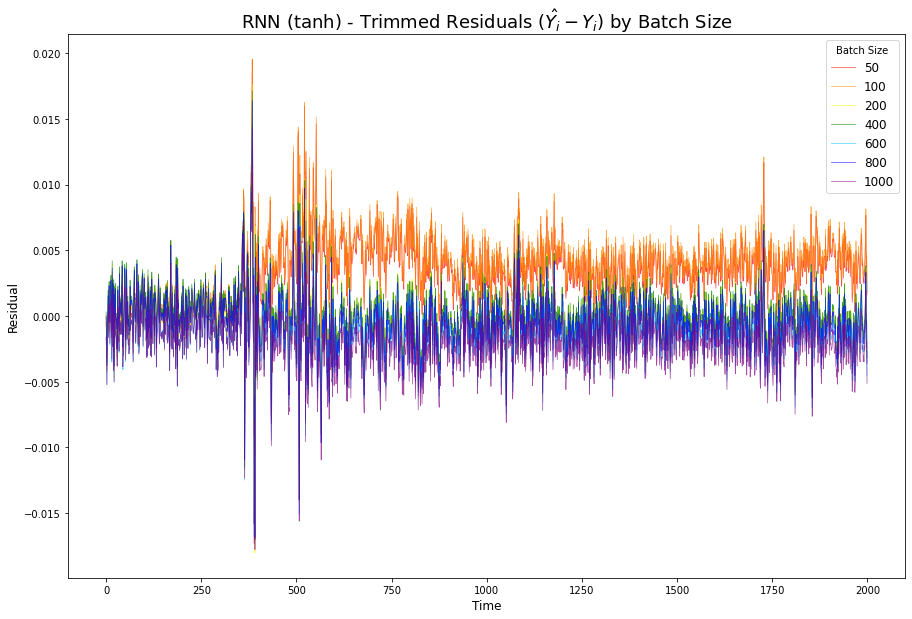

In [70]:
# Plot trimmed residuals by batch size -- RNN
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['rnn']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('RNN (tanh) - Trimmed Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

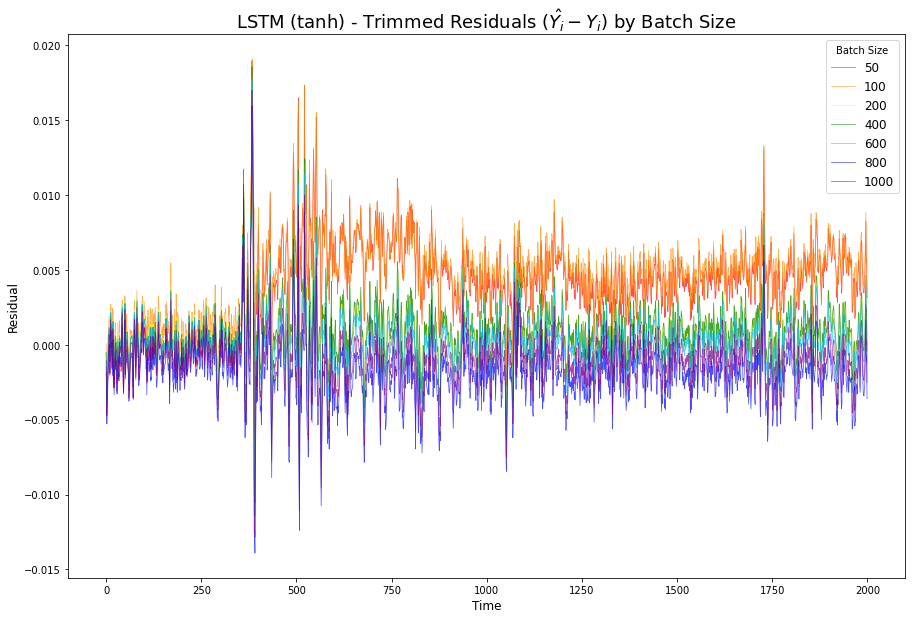

In [71]:
# Plot trimmed residuals by batch size -- LSTM
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['lstm']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('LSTM (tanh) - Trimmed Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

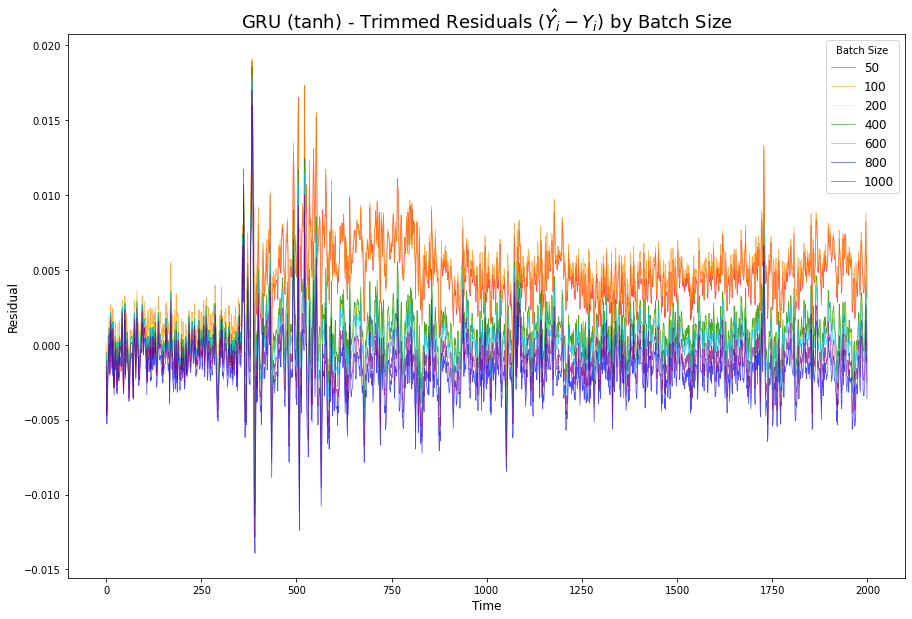

In [72]:
# Plot trimmed residuals by batch size -- GRU
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['lstm']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('GRU (tanh) - Trimmed Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

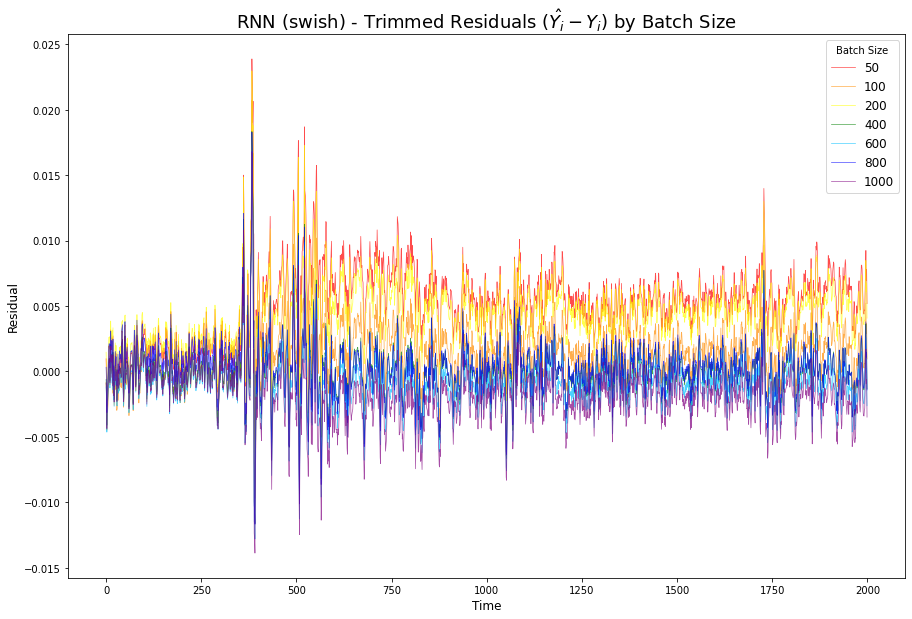

In [73]:
# Plot trimmed residuals by batch size -- sRNN
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['srnn']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('RNN (swish) - Trimmed Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

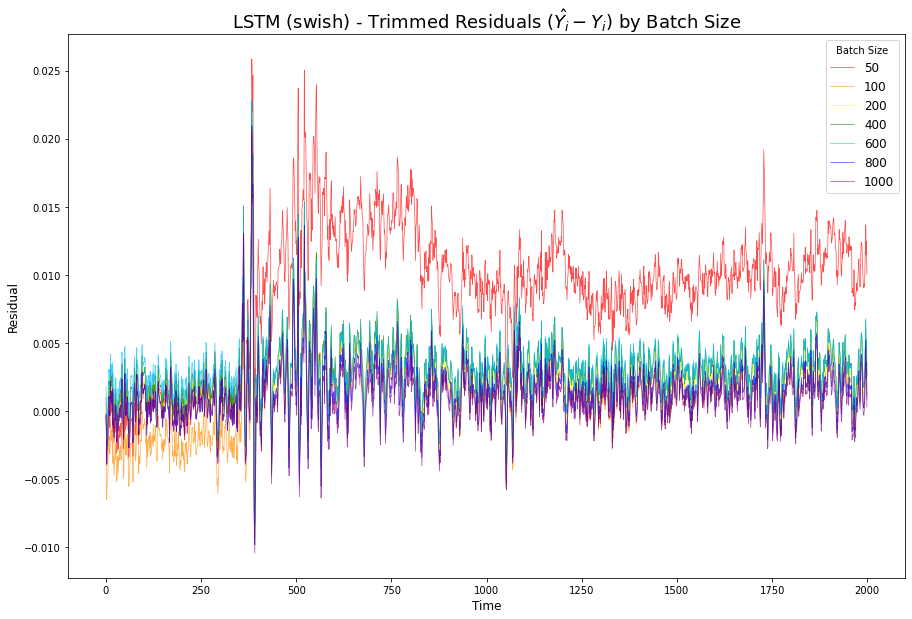

In [74]:
# Plot trimmed residuals by batch size -- sLSTM
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['slstm']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('LSTM (swish) - Trimmed Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

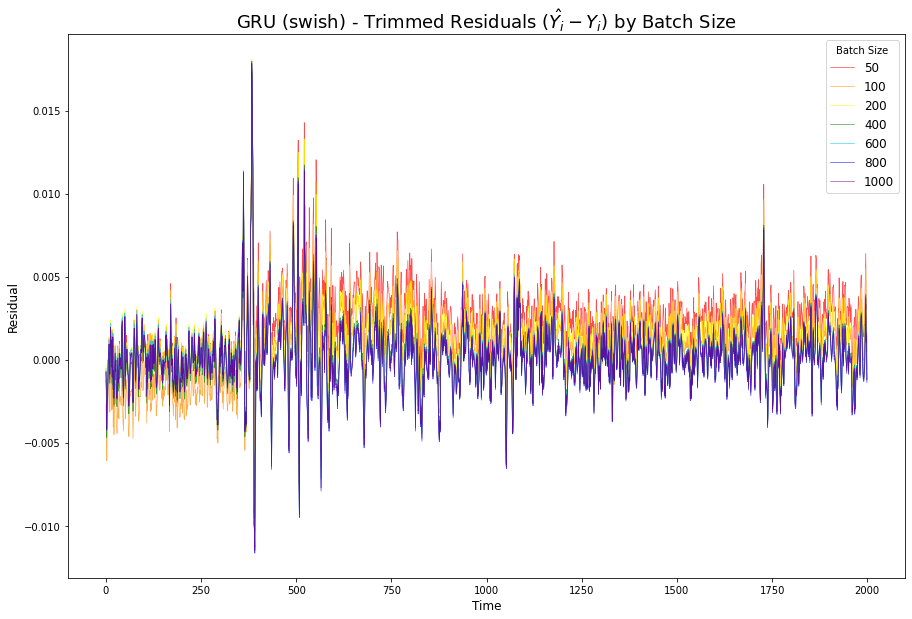

In [75]:
# Plot trimmed residuals by batch size -- sGRU
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, upper_limit)

for b in batches:
    residual = params['sgru']['predict'][b][:upper_limit] - y_test_reg[:upper_limit]
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('GRU (swish) - Trimmed Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

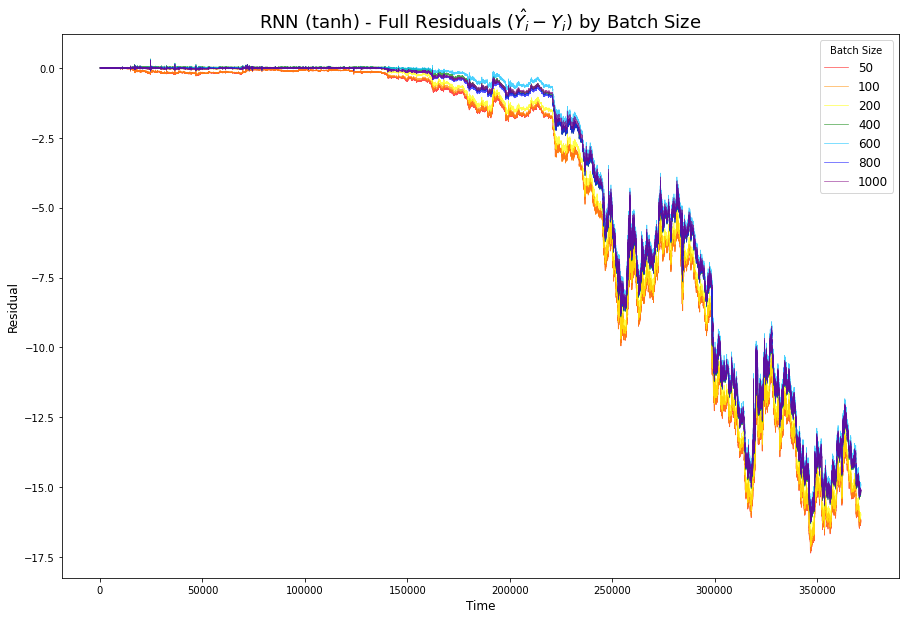

In [76]:
# Plot full residuals by batch size -- RNN
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))

for b in batches:
    residual = params['rnn']['predict'][b] - y_test_reg
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('RNN (tanh) - Full Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

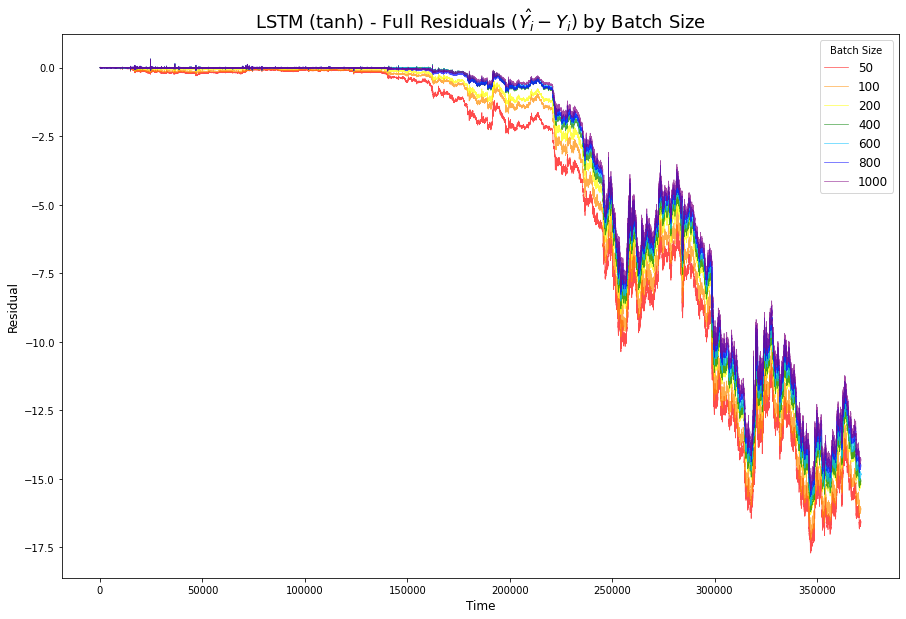

In [77]:
# Plot full residuals by batch size -- LSTM
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))

for b in batches:
    residual = params['lstm']['predict'][b] - y_test_reg
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('LSTM (tanh) - Full Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

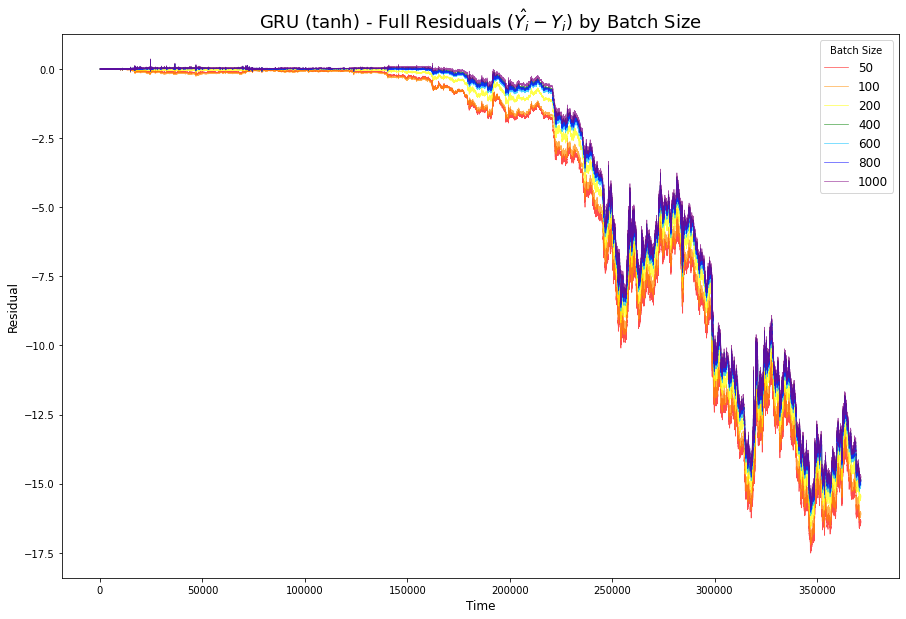

In [78]:
# Plot full residuals by batch size -- GRU
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))

for b in batches:
    residual = params['gru']['predict'][b] - y_test_reg
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('GRU (tanh) - Full Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

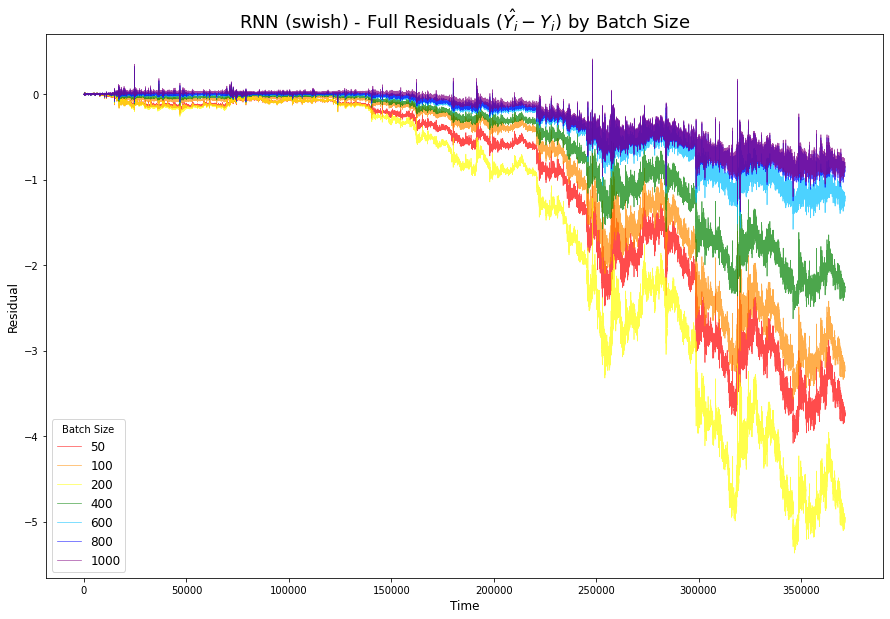

In [79]:
# Plot full residuals by batch size -- sRNN
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))

for b in batches:
    residual = params['srnn']['predict'][b] - y_test_reg
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('RNN (swish) - Full Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

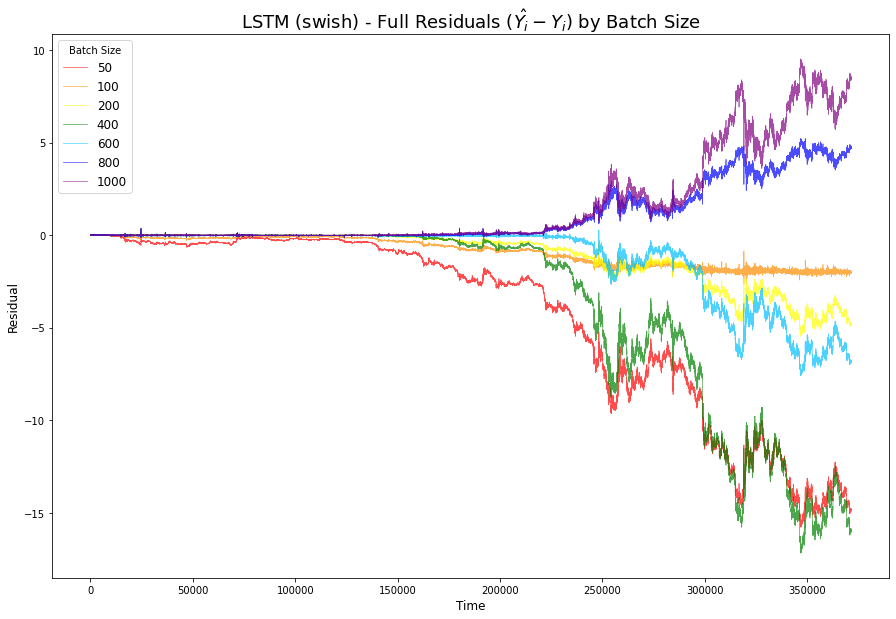

In [80]:
# Plot full residuals by batch size -- sLSTM
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))

for b in batches:
    residual = params['slstm']['predict'][b] - y_test_reg
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('LSTM (swish) - Full Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

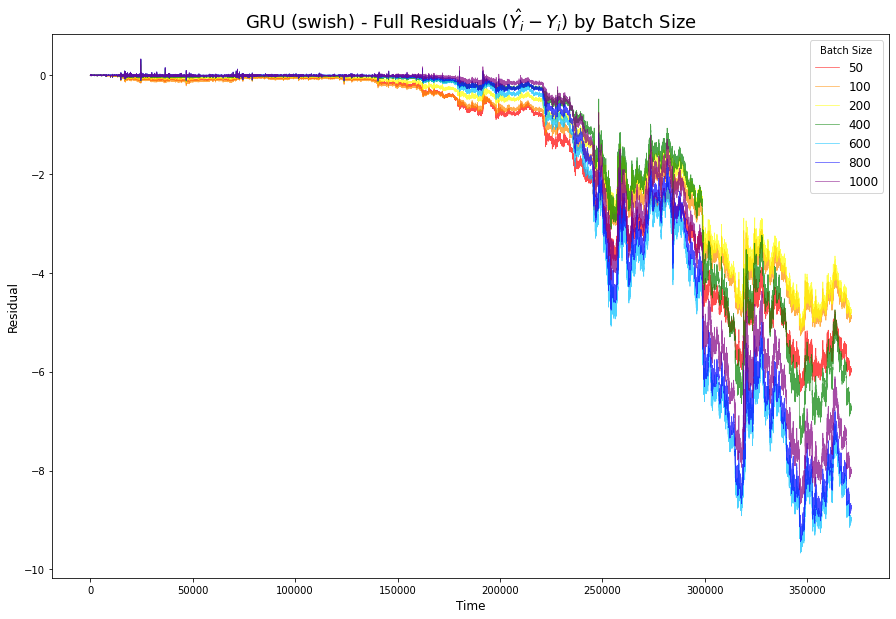

In [81]:
# Plot full residuals by batch size -- sGRU
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))

for b in batches:
    residual = params['sgru']['predict'][b] - y_test_reg
    plt.plot(_x, residual, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('GRU (swish) - Full Residuals ($\hat{Y_i} - Y_i$) by Batch Size', fontsize = 18)
plt.show()

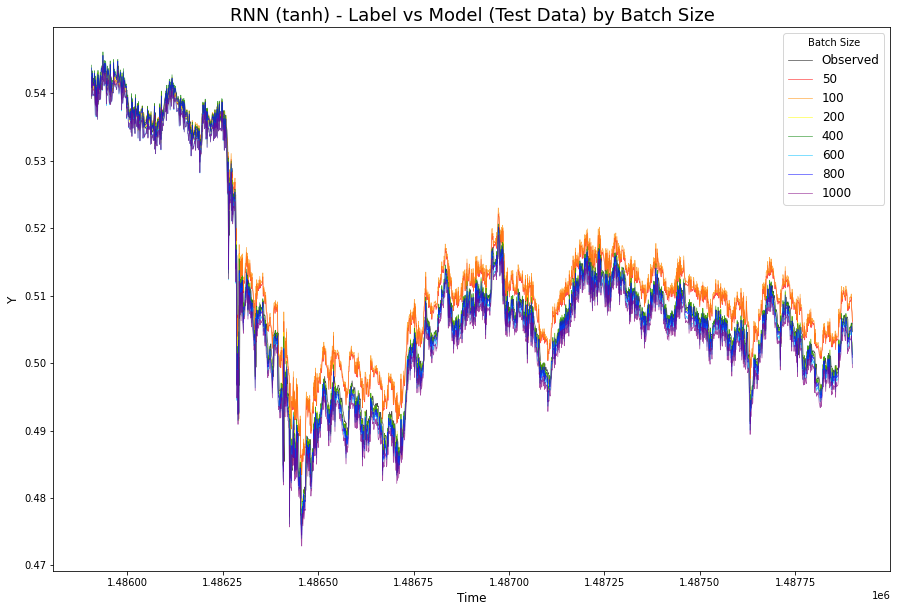

In [82]:
# Plot full prediction vs label performance -- RNN
fig = plt.figure(figsize = (15, 10))

plt.plot(test.index[step_lag : upper_limit], test[features][step_lag : upper_limit], linewidth = 0.7,
         color = 'black', label = 'Observed', alpha = 0.7)

for b in batches:
    plt.plot(test.index[step_lag : upper_limit], 
             params['rnn']['predict'][b][step_lag : upper_limit], linewidth = 0.7,
             color = colors[b], label = str(b), alpha = 0.7)
    

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('RNN (tanh) - Label vs Model (Test Data) by Batch Size', fontsize = 18)

plt.show()

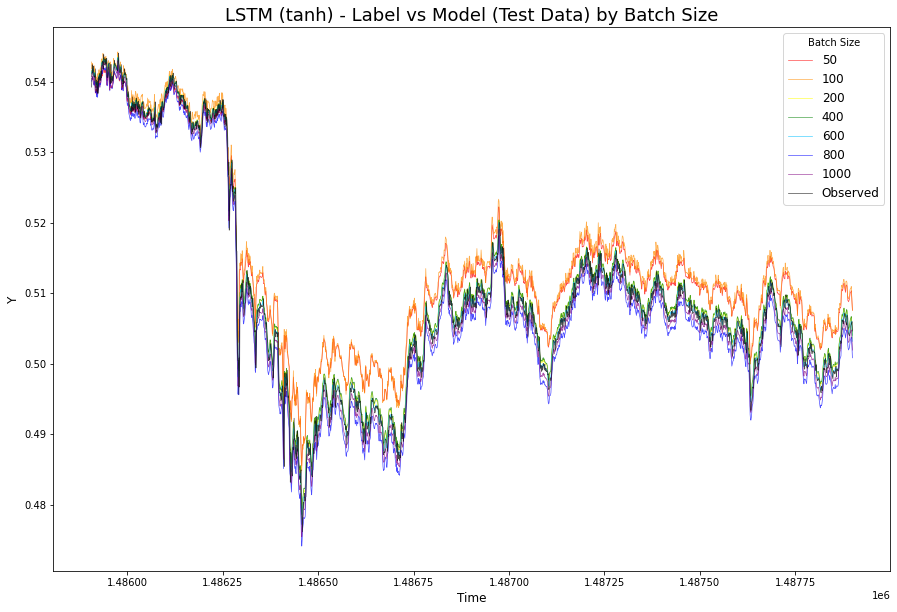

In [83]:
# Plot full prediction vs label performance -- LSTM
fig = plt.figure(figsize = (15, 10))
upper_limit = 2000

for b in batches:
    plt.plot(test.index[step_lag : upper_limit], params['lstm']['predict'][b][step_lag : upper_limit], linewidth = 0.7,
             color = colors[b], label = str(b), alpha = 0.7)
    
plt.plot(test.index[step_lag : upper_limit], 
         test[features][step_lag : upper_limit], linewidth = 0.7,
         color = 'black', label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('LSTM (tanh) - Label vs Model (Test Data) by Batch Size', fontsize = 18)

plt.show()

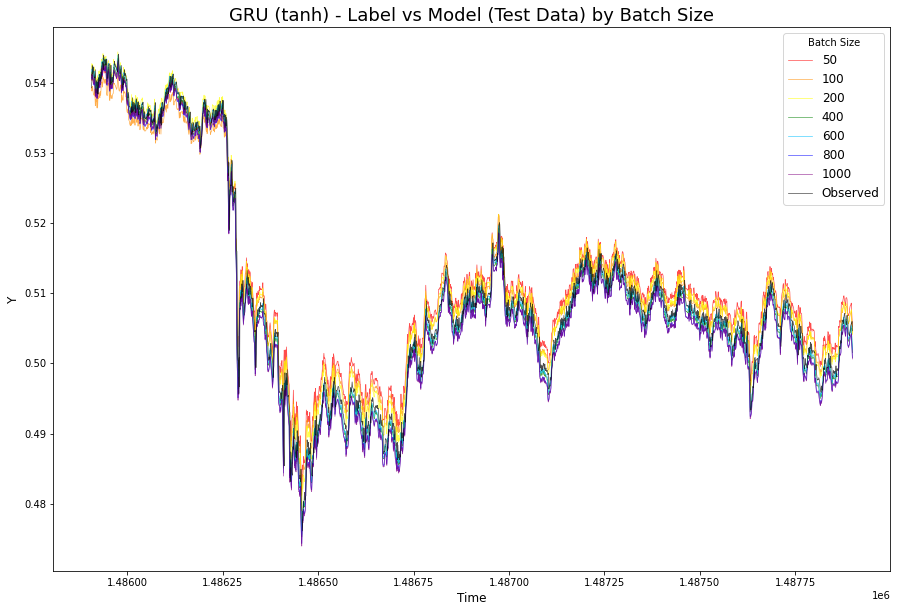

In [84]:
# Plot full prediction vs label performance -- GRU
fig = plt.figure(figsize = (15, 10))

for b in batches:
    plt.plot(test.index[step_lag : upper_limit], params['gru']['predict'][b][step_lag : upper_limit], linewidth = 0.7,
             color = colors[b], label = str(b), alpha = 0.7)
    
plt.plot(test.index[step_lag : upper_limit], 
         test[features][step_lag : upper_limit], linewidth = 0.7,
         color = 'black', label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('GRU (tanh) - Label vs Model (Test Data) by Batch Size', fontsize = 18)

plt.show()

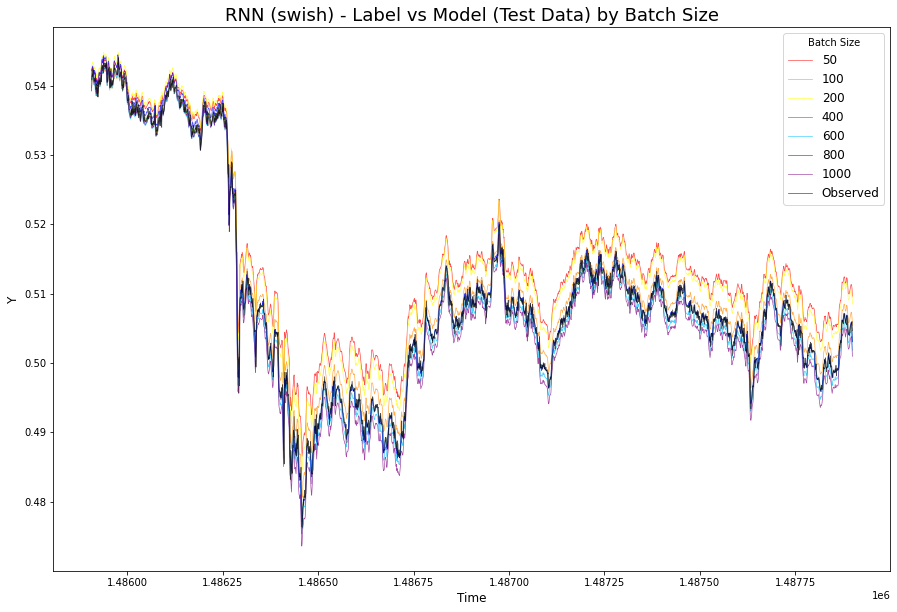

In [85]:
# Plot full prediction vs label performance -- sRNN
fig = plt.figure(figsize = (15, 10))

for b in batches:
    plt.plot(test.index[step_lag : upper_limit], params['srnn']['predict'][b][step_lag : upper_limit], linewidth = 0.7,
             color = colors[b], label = str(b), alpha = 0.7)
    
plt.plot(test.index[step_lag : upper_limit], 
         test[features][step_lag : upper_limit], linewidth = 0.7,
         color = 'black', label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('RNN (swish) - Label vs Model (Test Data) by Batch Size', fontsize = 18)

plt.show()

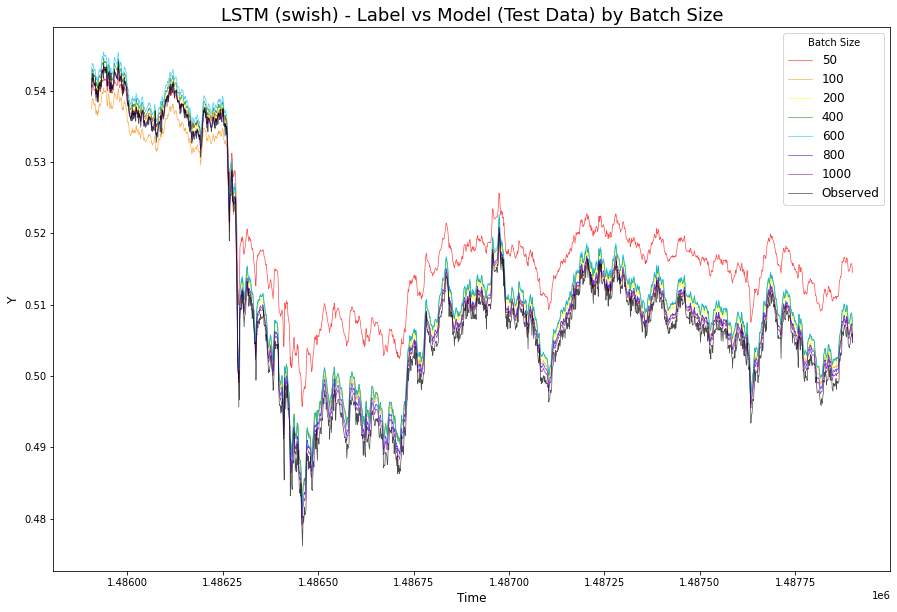

In [86]:
# Plot full prediction vs label performance -- sLSTM
fig = plt.figure(figsize = (15, 10))

for b in batches:
    plt.plot(test.index[step_lag : upper_limit], params['slstm']['predict'][b][step_lag : upper_limit], linewidth = 0.7,
             color = colors[b], label = str(b), alpha = 0.7)
    
plt.plot(test.index[step_lag : upper_limit], 
         test[features][step_lag : upper_limit], linewidth = 0.7,
         color = 'black', label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('LSTM (swish) - Label vs Model (Test Data) by Batch Size', fontsize = 18)

plt.show()

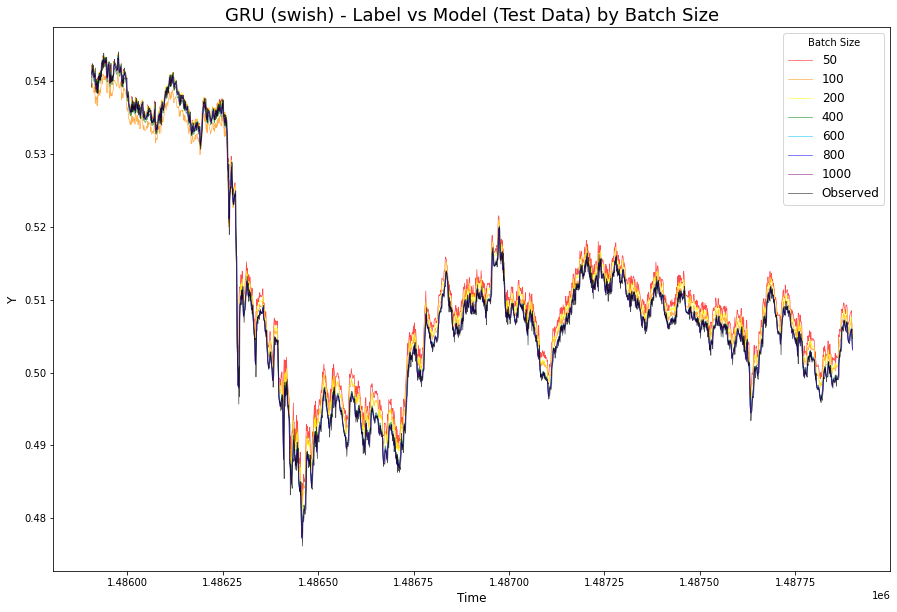

In [87]:
# Plot full prediction vs label performance -- sGRU
fig = plt.figure(figsize = (15, 10))

for b in batches:
    plt.plot(test.index[step_lag : upper_limit], params['sgru']['predict'][b][step_lag : upper_limit], linewidth = 0.7,
             color = colors[b], label = str(b), alpha = 0.7)
    
plt.plot(test.index[step_lag : upper_limit], 
         test[features][step_lag : upper_limit], linewidth = 0.7,
         color = 'black', label = 'Observed', alpha = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('GRU (swish) - Label vs Model (Test Data) by Batch Size', fontsize = 18)

plt.show()

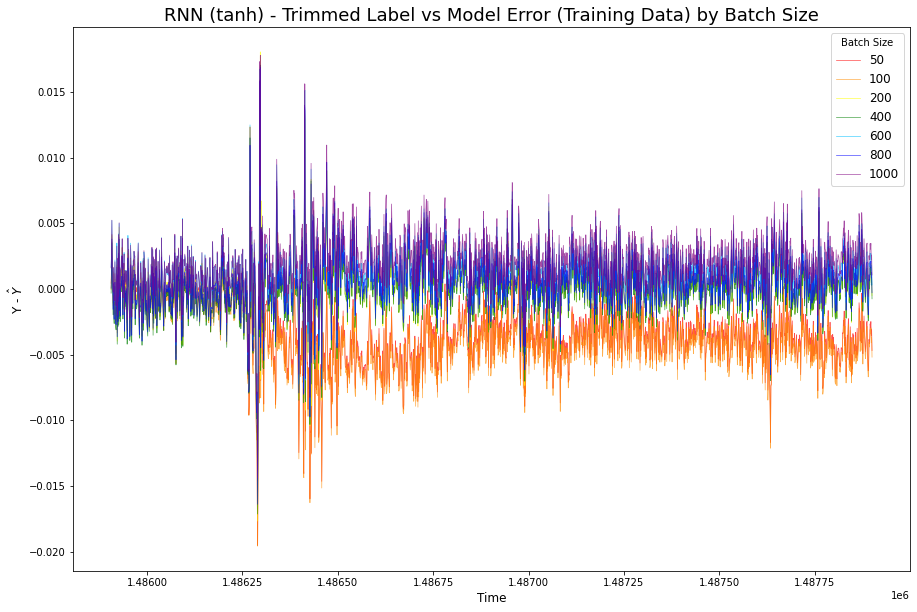

In [88]:
# Plot trimmed prediction vs label error - RNN
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]

for b in batches:
    nn_y_plot = test[features][step_lag : upper_limit] - params['rnn']['predict'][b][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('RNN (tanh) - Trimmed Label vs Model Error (Training Data) by Batch Size', fontsize = 18)

plt.show()

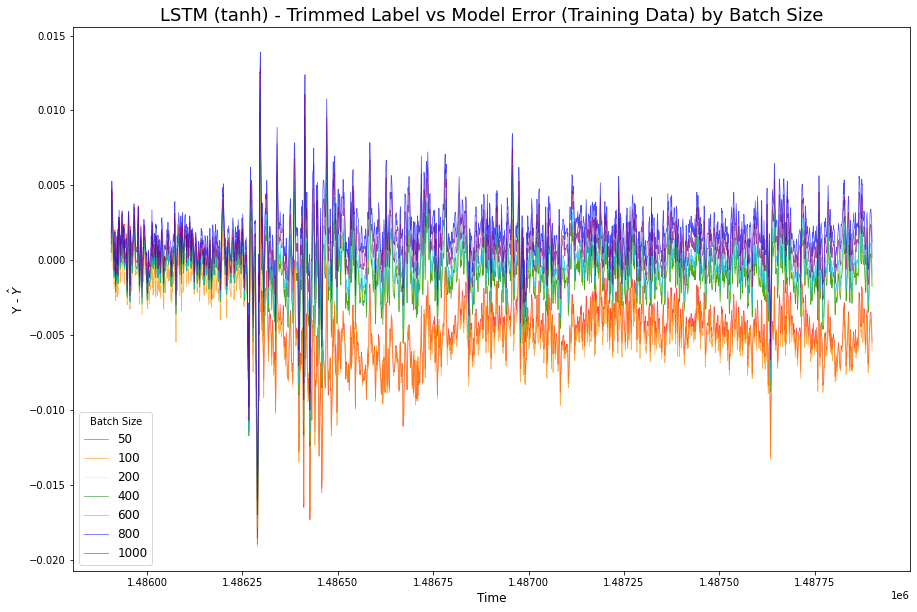

In [89]:
# Plot trimmed prediction vs label error - LSTM
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]

for b in batches:
    nn_y_plot = test[features][step_lag : upper_limit] - params['lstm']['predict'][b][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('LSTM (tanh) - Trimmed Label vs Model Error (Training Data) by Batch Size', fontsize = 18)

plt.show()

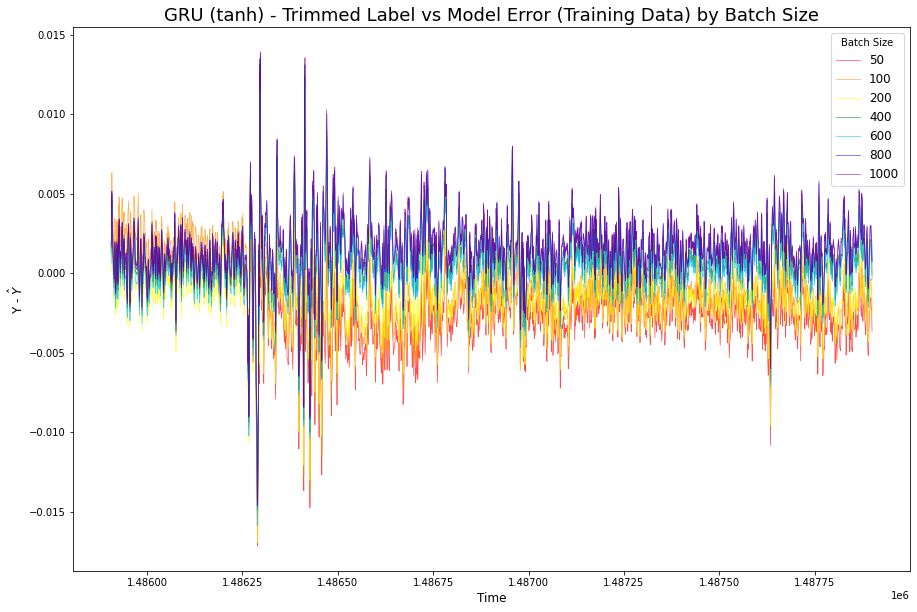

In [90]:
# Plot trimmed prediction vs label error - GRU
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]

for b in batches:
    nn_y_plot = test[features][step_lag : upper_limit] - params['gru']['predict'][b][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('GRU (tanh) - Trimmed Label vs Model Error (Training Data) by Batch Size', fontsize = 18)

plt.show()

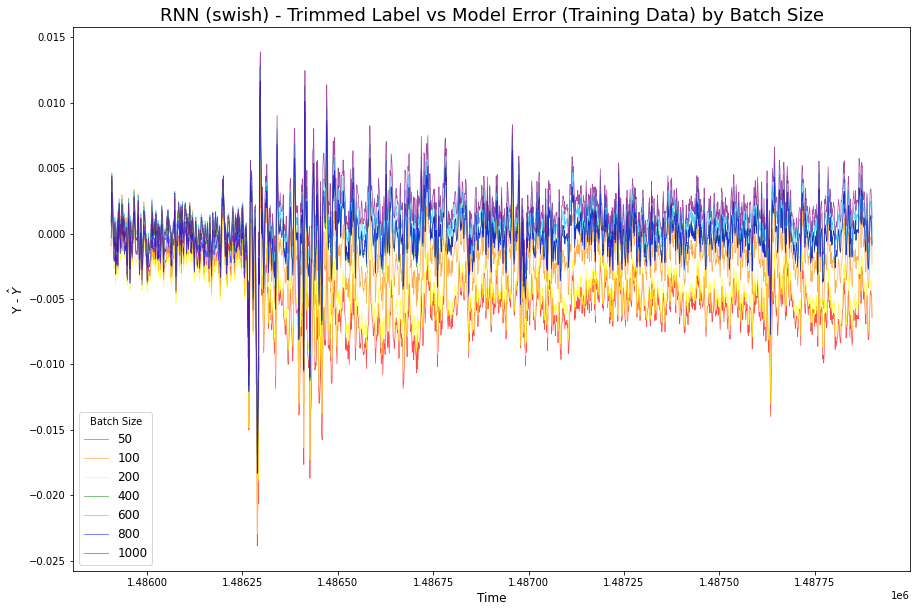

In [91]:
# Plot trimmed prediction vs label error - sRNN
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]

for b in batches:
    nn_y_plot = test[features][step_lag : upper_limit] - params['srnn']['predict'][b][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('RNN (swish) - Trimmed Label vs Model Error (Training Data) by Batch Size', fontsize = 18)

plt.show()

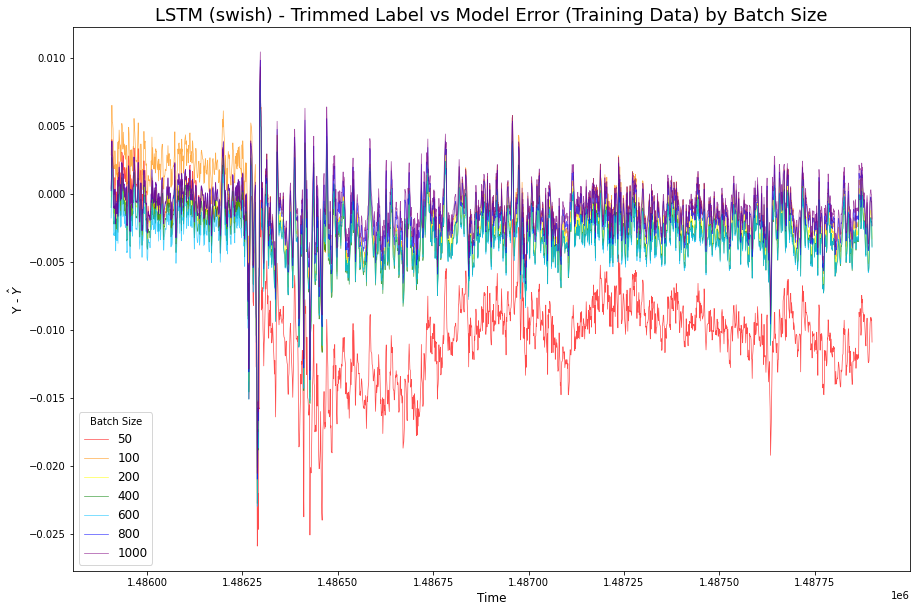

In [92]:
# Plot trimmed prediction vs label error - sLSTM
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]

for b in batches:
    nn_y_plot = test[features][step_lag : upper_limit] - params['slstm']['predict'][b][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('LSTM (swish) - Trimmed Label vs Model Error (Training Data) by Batch Size', fontsize = 18)

plt.show()

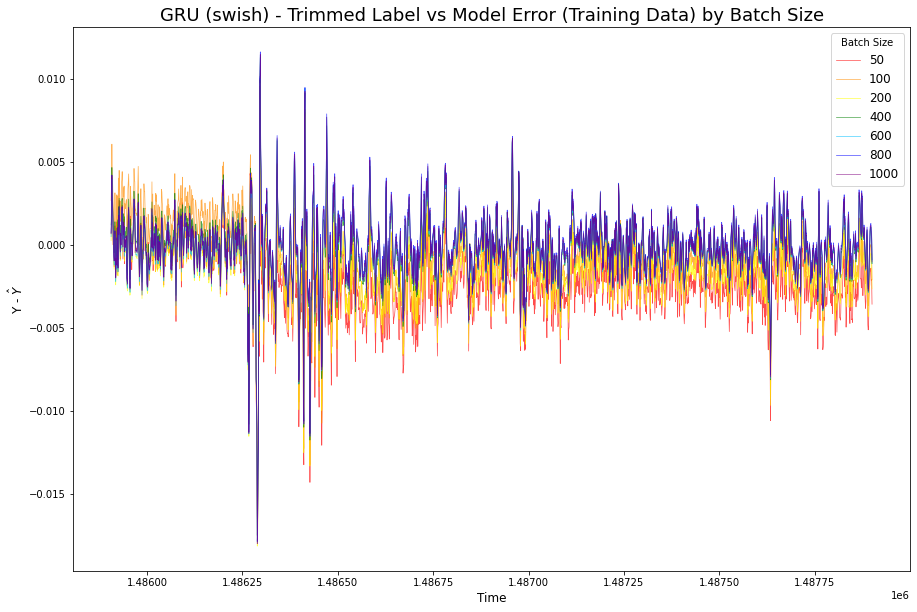

In [93]:
# Plot trimmed prediction vs label error - sGRU
fig = plt.figure(figsize = (15, 10))
dim = len(test.index[step_lag : upper_limit])
x_plot = test.index[step_lag : upper_limit]

for b in batches:
    nn_y_plot = test[features][step_lag : upper_limit] - params['sgru']['predict'][b][: upper_limit - (step_lag), 0].reshape(dim, 1)
    plt.plot(x_plot, nn_y_plot, color = colors[b], label = str(b), alpha = 0.7, linewidth = 0.7)

plt.legend(loc = 'best', title = 'Batch Size', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Y - $\hat{Y}$', fontsize = 12)
plt.title('GRU (swish) - Trimmed Label vs Model Error (Training Data) by Batch Size', fontsize = 18)

plt.show()

In [94]:
print('Model Errors by Batch Size:')
print()

for k in params.keys():
    print('Model: ' + params[k]['label'] )
    for b in batches:
        print('   Batch Size - [ ' + str(b) + ' ]')
        print('      Train MSE = ' + str(params[k]['MSE_train'][b]) )
        print('      Test MSE = ' + str(params[k]['MSE_test'][b]) )
        print()

Model Errors by Batch Size:

Model: RNN
   Batch Size - [ 50 ]
      Train MSE = 0.05527880955519431
      Test MSE = 47.605629089734876

   Batch Size - [ 100 ]
      Train MSE = 0.032664004681023734
      Test MSE = 47.4487442869647

   Batch Size - [ 200 ]
      Train MSE = 0.01814337023272309
      Test MSE = 45.58480019527721

   Batch Size - [ 400 ]
      Train MSE = 0.00528128786622673
      Test MSE = 39.48247556843417

   Batch Size - [ 600 ]
      Train MSE = 0.002075411128198343
      Test MSE = 37.51279880357813

   Batch Size - [ 800 ]
      Train MSE = 0.0072212805608802035
      Test MSE = 39.212361917159605

   Batch Size - [ 1000 ]
      Train MSE = 0.0065302113154487125
      Test MSE = 38.79400163868471

Model: LSTM
   Batch Size - [ 50 ]
      Train MSE = 0.10071121435827261
      Test MSE = 51.111767752717995

   Batch Size - [ 100 ]
      Train MSE = 0.06034449733321799
      Test MSE = 46.42033737918649

   Batch Size - [ 200 ]
      Train MSE = 0.029272990959879

In [95]:
print('Near-term Forecasting Accuracy')
print()

for k in params.keys():
    print('Model: ' + params[k]['label'])
    for b in batches:
        temp = mean_squared_error(test[features][step_lag : 200], params[k]['predict'][b][step_lag : 200])
        print('\tBatch size [ ' + str(b) + ' ] - MSE = ' + str(temp))
        print()

Near-term Forecasting Accuracy

Model: RNN
	Batch size [ 50 ] - MSE = 1.5528708871745192e-06

	Batch size [ 100 ] - MSE = 2.1500259735086664e-06

	Batch size [ 200 ] - MSE = 2.2405712828030584e-06

	Batch size [ 400 ] - MSE = 2.7627506746093738e-06

	Batch size [ 600 ] - MSE = 3.301121827231001e-06

	Batch size [ 800 ] - MSE = 2.2304963425457977e-06

	Batch size [ 1000 ] - MSE = 3.1475086402141722e-06

Model: LSTM
	Batch size [ 50 ] - MSE = 1.6423624407324487e-06

	Batch size [ 100 ] - MSE = 2.0696925700567603e-06

	Batch size [ 200 ] - MSE = 8.410335366185752e-07

	Batch size [ 400 ] - MSE = 6.456576475401874e-07

	Batch size [ 600 ] - MSE = 7.025589825827553e-07

	Batch size [ 800 ] - MSE = 2.2633202018887793e-06

	Batch size [ 1000 ] - MSE = 9.421392307296222e-07

Model: GRU
	Batch size [ 50 ] - MSE = 1.7722574821036003e-06

	Batch size [ 100 ] - MSE = 6.0773326719529915e-06

	Batch size [ 200 ] - MSE = 1.5231840588435826e-06

	Batch size [ 400 ] - MSE = 1.3810711887968474e-06

	Bat